# M508D Big Data Analytics

## Problem Statement: Enhancing Support Efficiency by Automatically Categorizing Customer Queries.

## Link to the dataset 📂: https://www.kaggle.com/datasets/thoughtvector/customer-support-on-twitter

## Business Problem 💼:

Business organizations of today get thousands of customer requests from different sources like email, chat, contact forms, and so on. If these requests were handled manually, it would be very inefficient, very much prone to errors, and very expensive. The same problem will occur as a result of delays in routing, which leads to longer resolution times, poor customer experience, and missed SLAs.

It is highly likely that our company, which operates in the e-commerce sector, will set up an automated system to sort the support tickets that come in the given categories. The purpose is to decrease the human workload, to make the first-response times better, and to send the queries to the right departments immediately.

## Importance 🚀:

- Faster ticket triaging leads to customer satisfaction (CSAT) being higher.  
- The problems can be solved by the internal agents and they do not have to waste their time in sorting the issues.  
- It also reduces misrouting e.g., if the technical queries are accidentally sent to billing then it will be reduced.

## Formulated as an NLP Task 🔎:

This problem can be framed as a multi-class text classification task.
- Input: It is in the form of a text of a customer query/ticket.  
- Output: One of several predefined categories (e.g., `Billing`, `Technical`, `Shipping`, `Returns`, `Product Info`, `cancellations`, etc.).

## Dataset Collection Strategy 📚:

For this, we will be using a dataset inspired and derived from real-world support tickets. Hence, we select the dataset named "Customer Support on Twitter" available at Kaggle. It contains tweets by customers and replies by support teams of companies such as Apple, Xbox, etc.

We:
 - Are going to get/extract customer-side queries only.  
 - Manually organize the tickets and group them into 6 to 8 broad support categories.

### Importing Libraries 📦

In [1]:
import pandas as pd
import numpy as np
import re
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.calibration import CalibratedClassifierCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import TruncatedSVD
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

### Loading the Dataset 📁

In [2]:
df = pd.read_csv("customer_support_tweets.csv")
print("✅ Dataset loaded successfully")
print(f"Shape: {df.shape}")
print("\nFirst 5 samples:")
display(df.head(5))

✅ Dataset loaded successfully
Shape: (2811774, 7)

First 5 samples:


tweet_id   author_id  inbound                      created_at  \
0         1  sprintcare    False  Tue Oct 31 22:10:47 +0000 2017   
1         2      115712     True  Tue Oct 31 22:11:45 +0000 2017   
2         3      115712     True  Tue Oct 31 22:08:27 +0000 2017   
3         4  sprintcare    False  Tue Oct 31 21:54:49 +0000 2017   
4         5      115712     True  Tue Oct 31 21:49:35 +0000 2017   

                                                text response_tweet_id  \
0  @115712 I understand. I would like to assist y...                 2   
1      @sprintcare and how do you propose we do that               NaN   
2  @sprintcare I have sent several private messag...                 1   
3  @115712 Please send us a Private Message so th...                 3   
4                                 @sprintcare I did.                 4   

   in_response_to_tweet_id  
0                      3.0  
1                      1.0  
2                      4.0  
3                      5.0  
4                      6.0

### Viewing Column Names 🔎

In [3]:
df.columns

Index(['tweet_id', 'author_id', 'inbound', 'created_at', 'text',
       'response_tweet_id', 'in_response_to_tweet_id'],
      dtype='object')

### Dataset Information 🧾

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2811774 entries, 0 to 2811773
Data columns (total 7 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   tweet_id                 int64  
 1   author_id                object 
 2   inbound                  bool   
 3   created_at               object 
 4   text                     object 
 5   response_tweet_id        object 
 6   in_response_to_tweet_id  float64
dtypes: bool(1), float64(1), int64(1), object(4)
memory usage: 131.4+ MB


### Checking for Missing Values 🕳️

In [5]:
print(df.isnull().sum().sort_values(ascending=True))

tweet_id                         0
author_id                        0
inbound                          0
created_at                       0
text                             0
in_response_to_tweet_id     794335
response_tweet_id          1040629
dtype: int64


### Statistical Overview 📊

In [6]:
print(df.describe())

           tweet_id  in_response_to_tweet_id
count  2.811774e+06             2.017439e+06
mean   1.504565e+06             1.463141e+06
std    8.616450e+05             8.665730e+05
min    1.000000e+00             1.000000e+00
25%    7.601652e+05             7.155105e+05
50%    1.507772e+06             1.439805e+06
75%    2.253296e+06             2.220646e+06
max    2.987950e+06             2.987950e+06


### Data preprocessing 🧹

Since the datset is very big, executing whole datset takes a lot of time so I initially extract customer posts from corporate Twitter conversations by filtering out responses from companies. To facilitate rapid experimentation, I then randomly select 100,000 of these customer tweets. After that, we display the first few rows of this filtered dataset to verify the data.

In [7]:
print("Filtering customer tweets...")
df = df[df['author_id'] != df['in_response_to_tweet_id']]
print(f"Post-filtering shape: {df.shape}")

SAMPLE_SIZE = 100000
df = df[['text']].dropna().sample(n=SAMPLE_SIZE, random_state=42)
print(f"Sampled {len(df)} tickets")

print("\nSample customer tickets:")
display(df.head(5))

Filtering customer tweets...
Post-filtering shape: (2811774, 7)
Sampled 100000 tickets

Sample customer tickets:


text
160535   @161252 What's that egg website people talk about
659248   Why!🤷🏻‍♀️ #iOS11 @AppleSupport https://t.co/BX...
2250310  @693975 We can assist you. We recommend updati...
1640680  @331912 @115955 Thats better than having an un...
1933623  @VirginAmerica is probably one of the best air...

### Heuristic Labeling of the tweets 🏷️

I develop a simple keyword-based rule system to automatize a customer help desk topic classification into such areas as Billing, Technical, Shipping, etc. Each tweet is analyzed for the presence of these keywords, and then a correct class is given.

In [8]:
def label_ticket(text):
    text = text.lower()
    
    billing_terms = ['refund', 'charge', 'bill', 'invoice', 'payment', 'overcharge', 'credit', 'fee']
    technical_terms = ['not working', 'issue', 'problem', 'error', 'bug', 'fix', 'crash', 'broken', 'login', 'password']
    shipping_terms = ['shipment', 'delivery', 'arrived', 'tracking', 'deliver', 'shipped', 'where is', 'late', 'carrier']
    return_terms = ['return', 'exchange', 'replace', 'warranty', 'defective', 'damaged', 'faulty']
    cancel_terms = ['cancel', 'unsubscribe', 'terminate', 'close account', 'stop service', 'end subscription']
    
    if any(term in text for term in billing_terms): return 'Billing'
    elif any(term in text for term in technical_terms): return 'Technical'
    elif any(term in text for term in shipping_terms): return 'Shipping'
    elif any(term in text for term in return_terms): return 'Returns'
    elif any(term in text for term in cancel_terms): return 'Cancellation'
    else: return 'Other'

df['label'] = df['text'].apply(label_ticket)# Enhanced labeling function
def label_ticket(text):
    text = text.lower()
    
    billing_terms = ['refund', 'charge', 'bill', 'invoice', 'payment', 'overcharge', 'credit', 'fee']
    technical_terms = ['not working', 'issue', 'problem', 'error', 'bug', 'fix', 'crash', 'broken', 'login', 'password']
    shipping_terms = ['shipment', 'delivery', 'arrived', 'tracking', 'deliver', 'shipped', 'where is', 'late', 'carrier']
    return_terms = ['return', 'exchange', 'replace', 'warranty', 'defective', 'damaged', 'faulty']
    cancel_terms = ['cancel', 'unsubscribe', 'terminate', 'close account', 'stop service', 'end subscription']
    
    if any(term in text for term in billing_terms): return 'Billing'
    elif any(term in text for term in technical_terms): return 'Technical'
    elif any(term in text for term in shipping_terms): return 'Shipping'
    elif any(term in text for term in return_terms): return 'Returns'
    elif any(term in text for term in cancel_terms): return 'Cancellation'
    else: return 'Other'

df['label'] = df['text'].apply(label_ticket)

#### The below boxplot identifies general features of tweet length instances extracted from different categories and illustrates the range of the dispersion, outliers, and means. It can identify whether certain subjects are elucidated in more words or fewer.

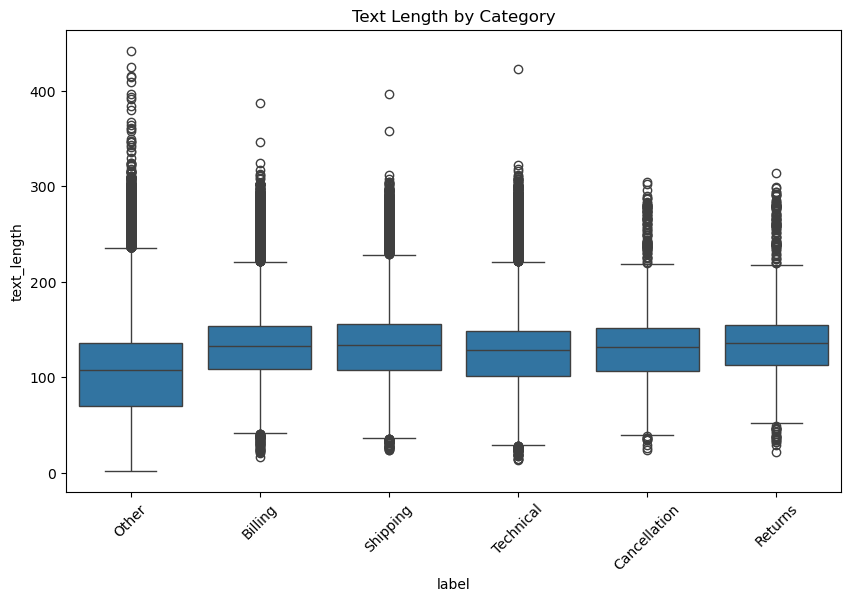

In [9]:
df['text_length'] = df['text'].apply(len)
plt.figure(figsize=(10,6))
sns.boxplot(x='label', y='text_length', data=df)
plt.title('Text Length by Category')
plt.xticks(rotation=45)
plt.show()

### Exploratory Data Analysis 📈

This bar plot shows the number of times each ticket category occurs. It is mainly used to detect the presence of class imbalance in the dataset. Below that, a word cloud for each category can be generated to pictorially portray the most frequent customer terms that are used for each issue category.

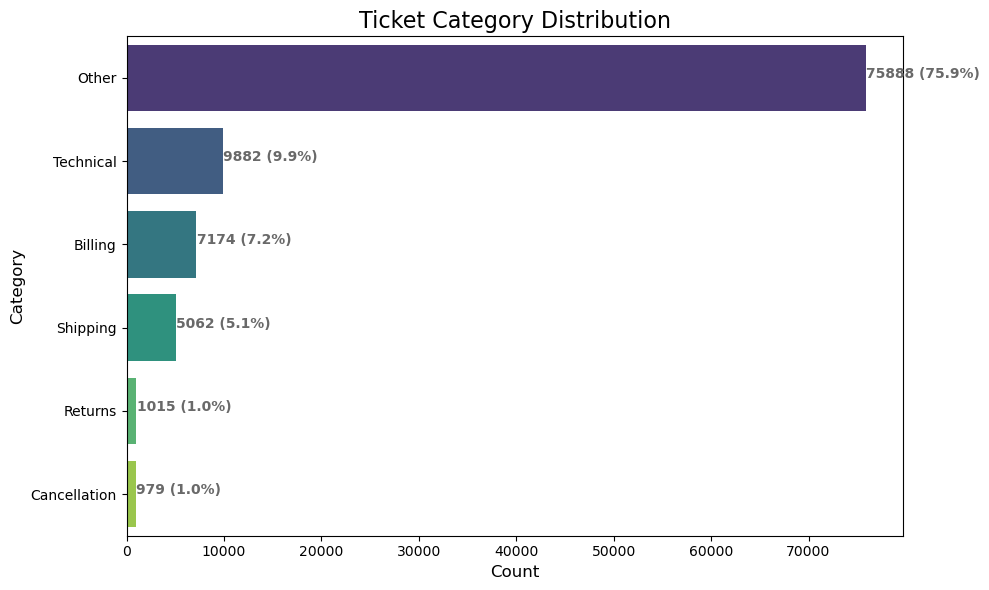

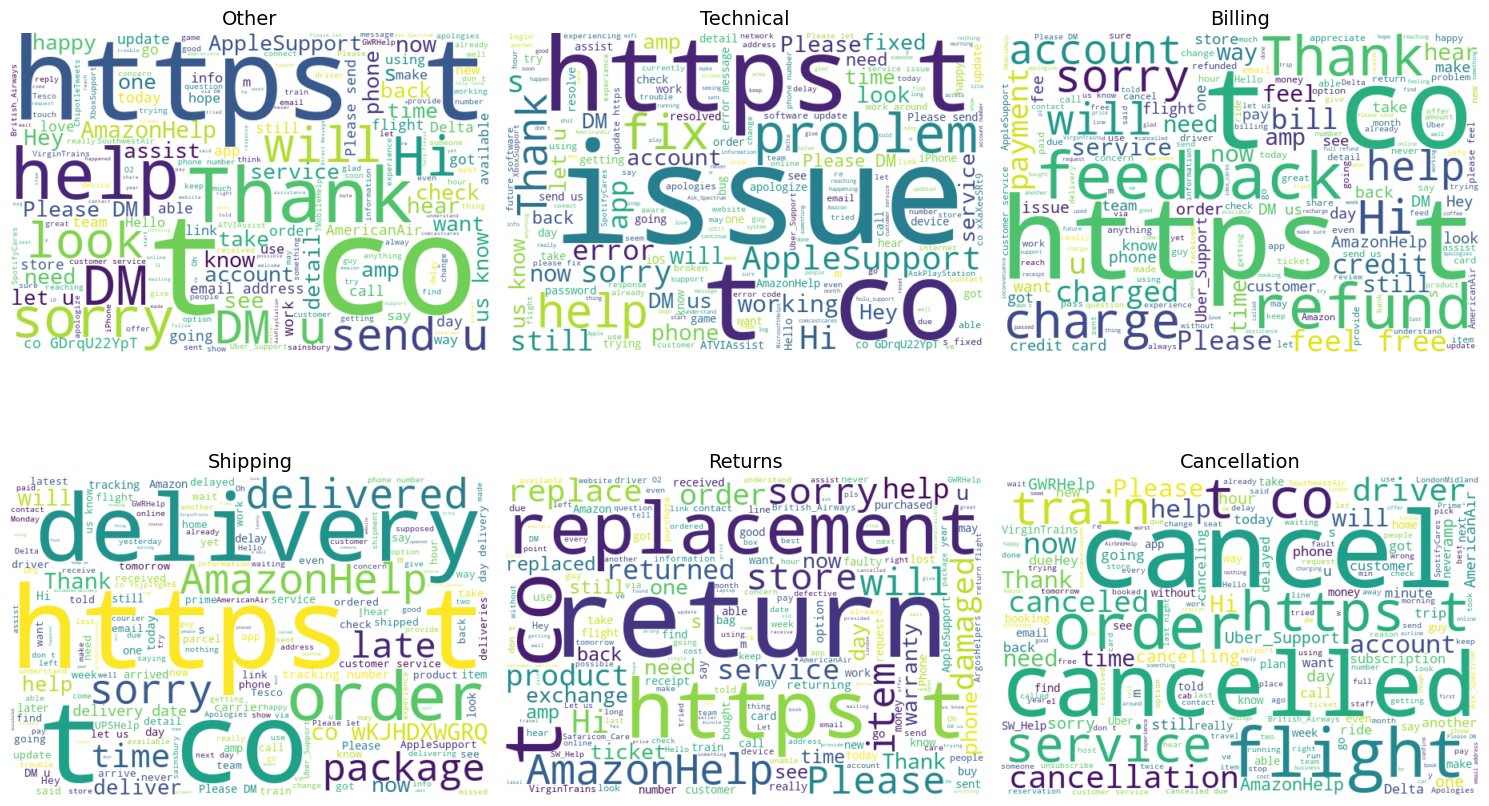

In [10]:
plt.figure(figsize=(10, 6))
label_counts = df['label'].value_counts()
ax = sns.barplot(x=label_counts.values, y=label_counts.index, palette="viridis")
plt.title('Ticket Category Distribution', fontsize=16)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Category', fontsize=12)

total = len(df)
for i, v in enumerate(label_counts.values):
    ax.text(v + 20, i, f"{v} ({v/total:.1%})", color='dimgrey', fontweight='bold')

plt.tight_layout()
plt.show()

from wordcloud import WordCloud

plt.figure(figsize=(15, 10))
for i, category in enumerate(label_counts.index):
    text = " ".join(df[df['label'] == category]['text'])
    wc = WordCloud(width=600, height=400, background_color='white').generate(text)
    
    plt.subplot(2, 3, i+1)
    plt.imshow(wc, interpolation='bilinear')
    plt.title(category, fontsize=14)
    plt.axis("off")

plt.tight_layout()
plt.show()

### Top Words Visualization 🌥️

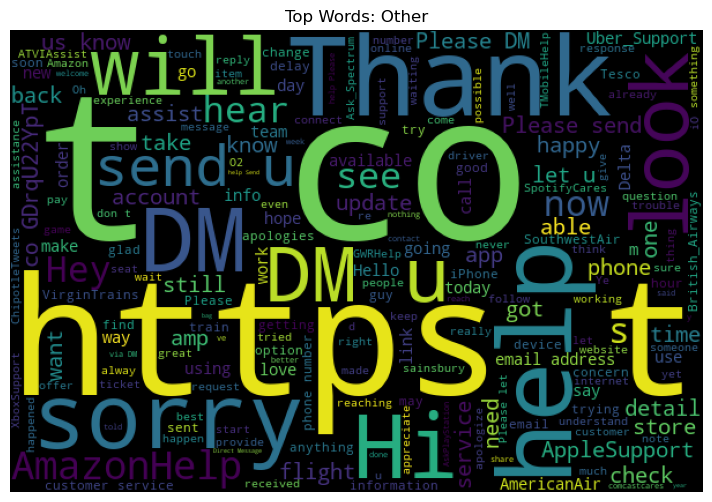

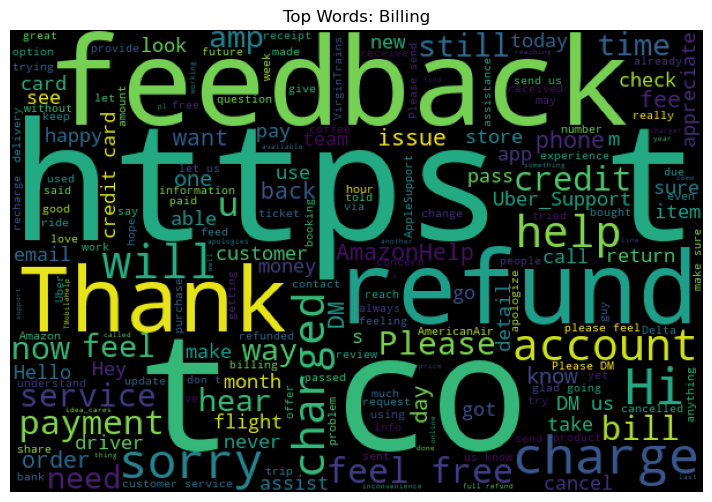

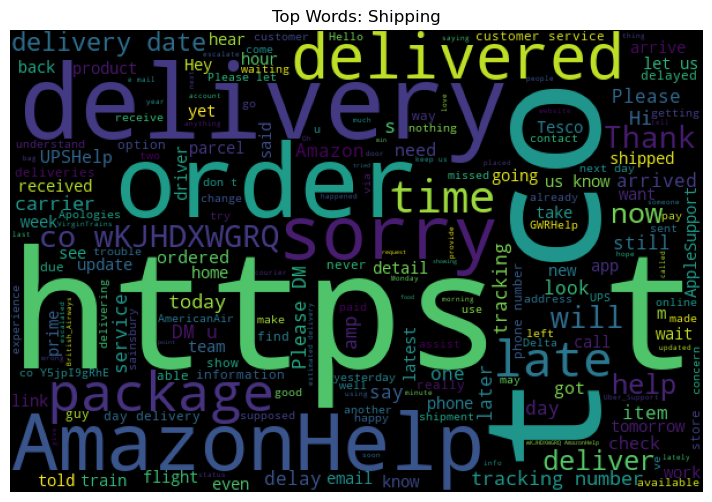

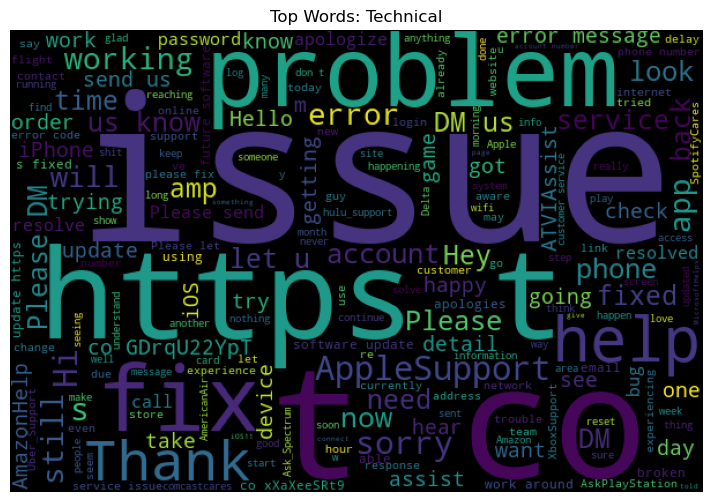

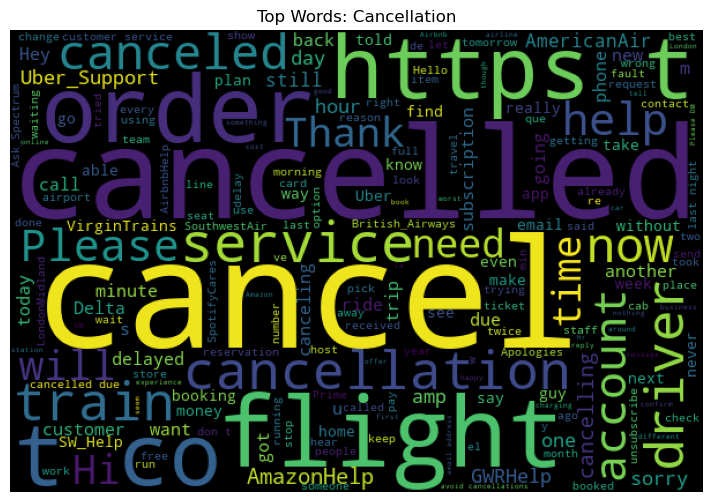

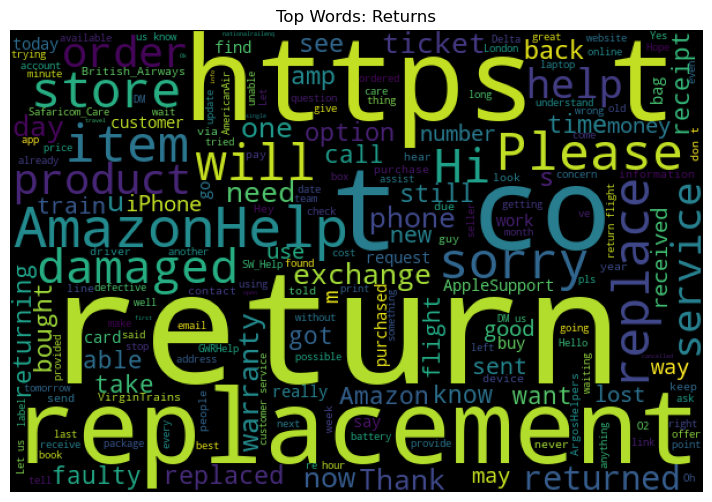

In [11]:
def plot_wordcloud(category):
    text = " ".join(df[df['label']==category]['text'])
    wordcloud = WordCloud(width=600, height=400).generate(text)
    plt.figure(figsize=(10,6))
    plt.imshow(wordcloud)
    plt.title(f'Top Words: {category}')
    plt.axis("off")
    plt.show()

for category in df['label'].unique():
    plot_wordcloud(category)

### Text Preprocessing 🧼

Textual data undergoes a rigorous cleaning procedure before being input into the model. The cleaning process comprises eliminating URLs, mentions, special characters, and stopwords, followed by lemmatization. We provide a before-and-after case to verify the change.

In [12]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
custom_stopwords = {'please', 'thank', 'thanks', 'hello', 'hi', 'hey', 'customer', 'support'}

def clean_text(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'[^A-Za-z\s]', '', text)
    
    words = text.lower().split()
    
    words = [lemmatizer.lemmatize(word) for word in words 
             if word not in stop_words and 
             word not in custom_stopwords and 
             len(word) > 2]
    
    return ' '.join(words)

print("Cleaning text data...")
df['clean_text'] = df['text'].apply(clean_text)

print("\nText cleaning example:")
print("Original:", df.iloc[0]['text'])
print("Cleaned:", df.iloc[0]['clean_text'])

Cleaning text data...

Text cleaning example:
Original: @161252 What's that egg website people talk about
Cleaned: whats egg website people talk


### Train-Test Split 🧪

We split the cleaned dataset into training and testing sets using `stratified sampling`, so that the class distribution remains consistent across both. This helps ensure a fair and reliable model evaluation.

In [13]:
X = df['clean_text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y
)

print("Train size:", len(X_train))
print("Test size:", len(X_test))
print("\nClass distribution in training set:")
print(y_train.value_counts(normalize=True))

Train size: 80000
Test size: 20000

Class distribution in training set:
label
Other           0.758875
Technical       0.098825
Billing         0.071737
Shipping        0.050625
Returns         0.010150
Cancellation    0.009787
Name: proportion, dtype: float64


### Feature Engineering with TF-IDF 🧠

The cleaned text is transformed into numerical features using a TF-IDF vectorizer, capturing both unigrams and bigrams. Then we limit the vocabulary size and remove excessively rare or frequent terms to enhance model performance.

In [14]:
vectorizer = TfidfVectorizer(
    max_features=8000,
    ngram_range=(1, 2),
    min_df=5,
    max_df=0.7
)

print("Fitting TF-IDF vectorizer...")
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

print("Feature matrix shape:")
print(f"Train: {X_train_vec.shape}, Test: {X_test_vec.shape}")

Fitting TF-IDF vectorizer...
Feature matrix shape:
Train: (80000, 8000), Test: (20000, 8000)


### Visualizing Feature Space 🔍

The large TF-IDF matrix which has many dimensions is reduced into two dimensions only by using Truncated SVD, then we plot the data points. This helps us in visualizing how clearly separated the categories are in feature space, although it is a very rough representation.

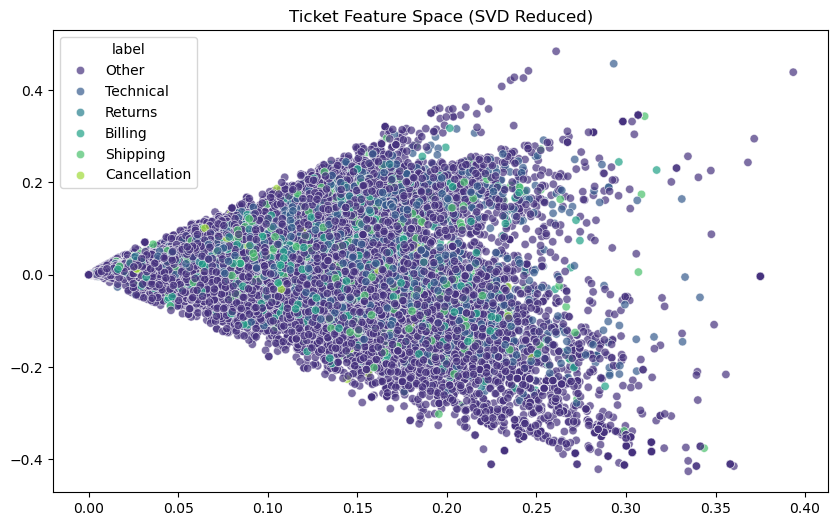

In [15]:
svd = TruncatedSVD(n_components=2)
X_svd = svd.fit_transform(X_train_vec)

plt.figure(figsize=(10,6))
sns.scatterplot(x=X_svd[:,0], y=X_svd[:,1], hue=y_train, palette='viridis', alpha=0.7)
plt.title('Ticket Feature Space (SVD Reduced)')
plt.show()

### Model Training ⚙️

We use `SGDClassifier`, a scalable linear model, to train on the vectorized features. This method is quick and effective for large datasets. We also carry out model calibration in order to enhance the trustworthiness of the probability estimates that the model provides.

In [16]:
model = SGDClassifier(
    loss='log_loss',
    penalty='l2',
    alpha=1e-4,
    max_iter=1000,
    tol=1e-3,
    n_jobs=-1,
    random_state=42
)

print("Training model...")
start_time = time.time()
model.fit(X_train_vec, y_train)

calibrated_model = CalibratedClassifierCV(model, cv=3, method='sigmoid')
calibrated_model.fit(X_train_vec, y_train)

Training model...


CalibratedClassifierCV(cv=3,
                       estimator=SGDClassifier(loss='log_loss', n_jobs=-1,
                                               random_state=42))

### Model Evaluation & Interpretation 🧮

We use model we have already trained to make predictions and then print out the complete classification report. We also draw a normalized confusion matrix which visually displays the places where the model is more mistake-prone relative to the actual class sizes.

Classification Report:
              precision    recall  f1-score   support

     Billing       1.00      0.51      0.68      1435
Cancellation       0.93      0.07      0.13       196
       Other       0.88      1.00      0.94     15178
     Returns       0.89      0.04      0.08       203
    Shipping       0.94      0.46      0.62      1012
   Technical       0.95      0.72      0.82      1976

    accuracy                           0.89     20000
   macro avg       0.93      0.47      0.54     20000
weighted avg       0.90      0.89      0.87     20000



<Figure size 1000x800 with 0 Axes>

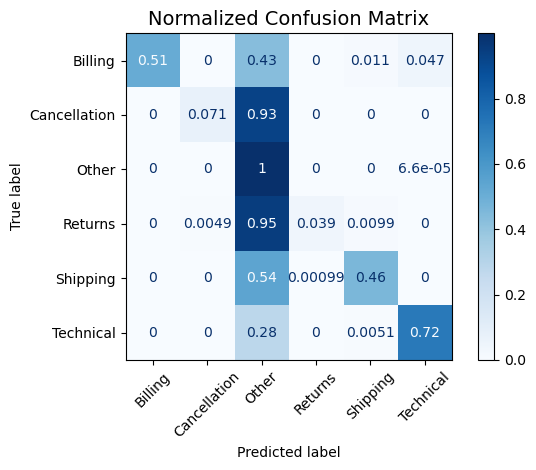


Top Predictive Features Analysis:


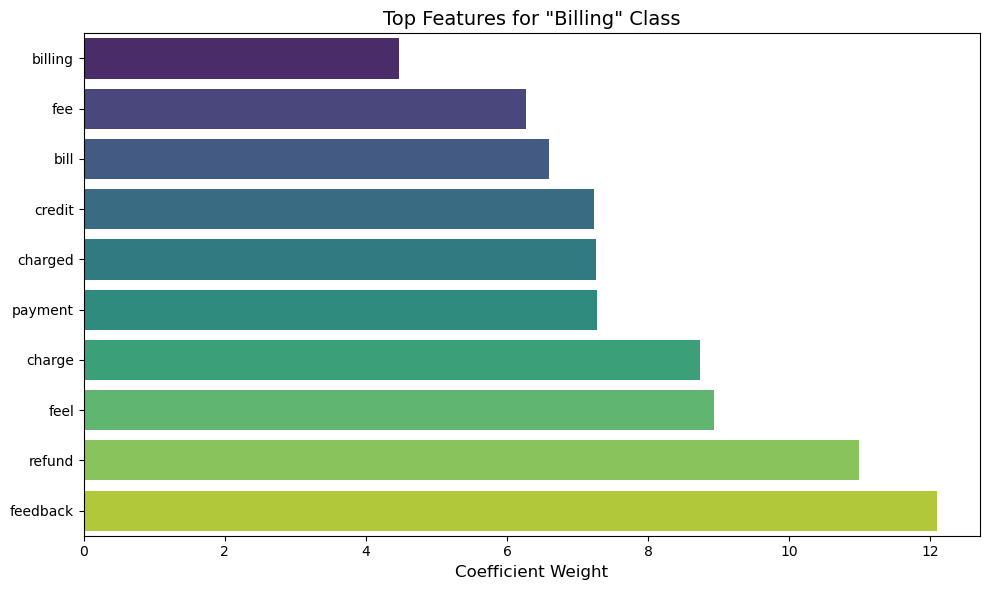

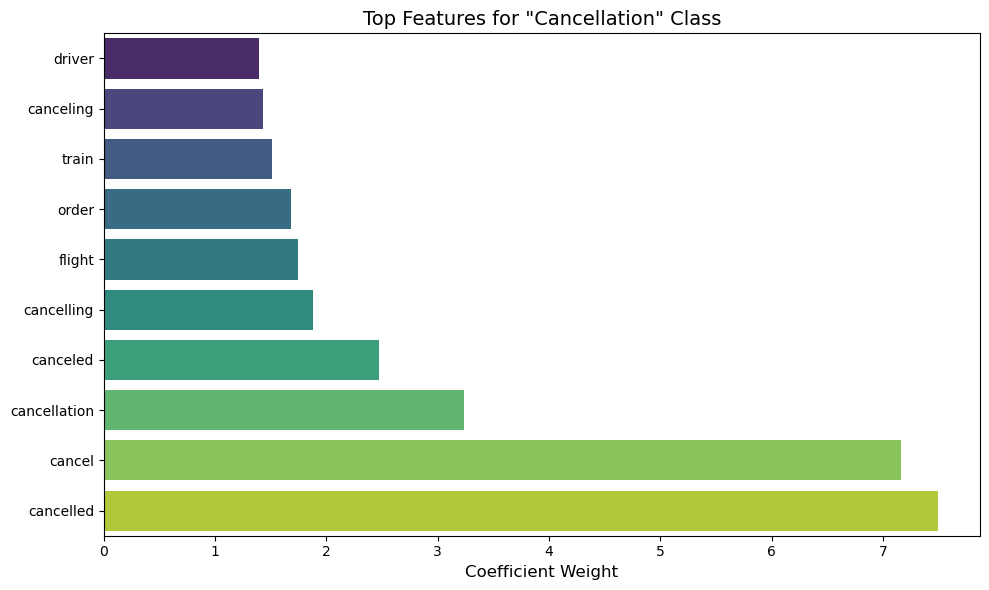

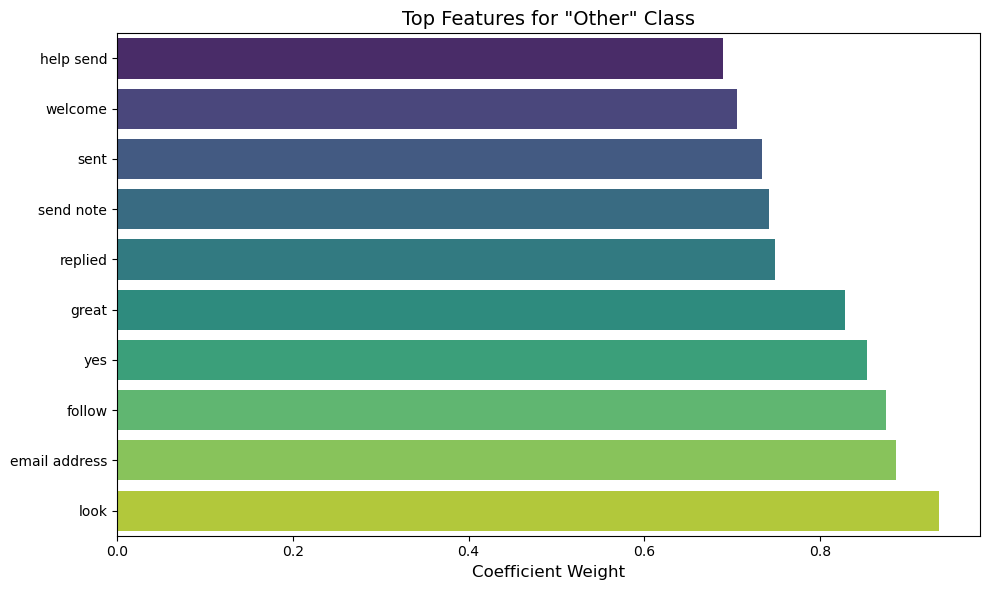

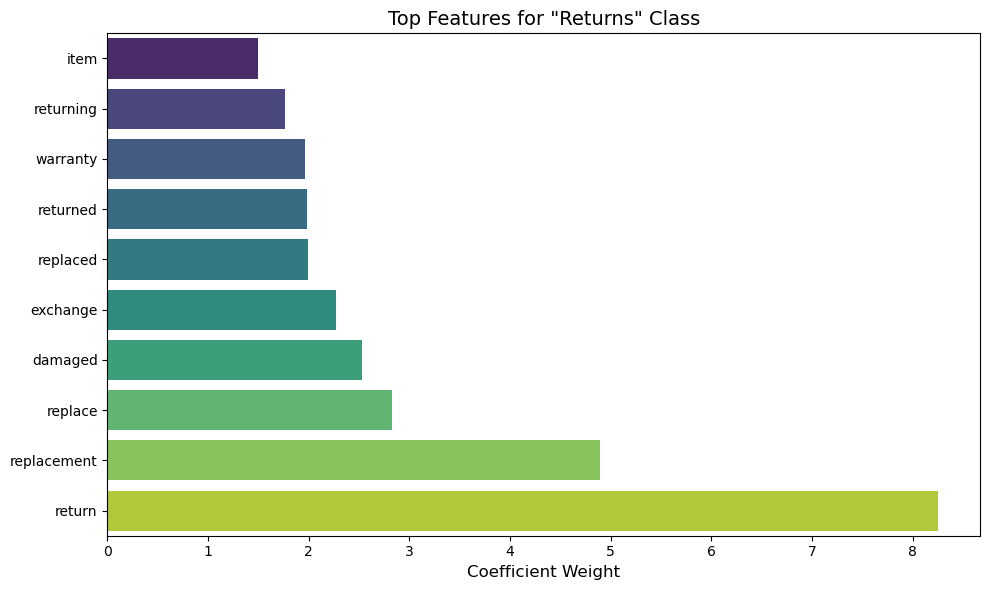

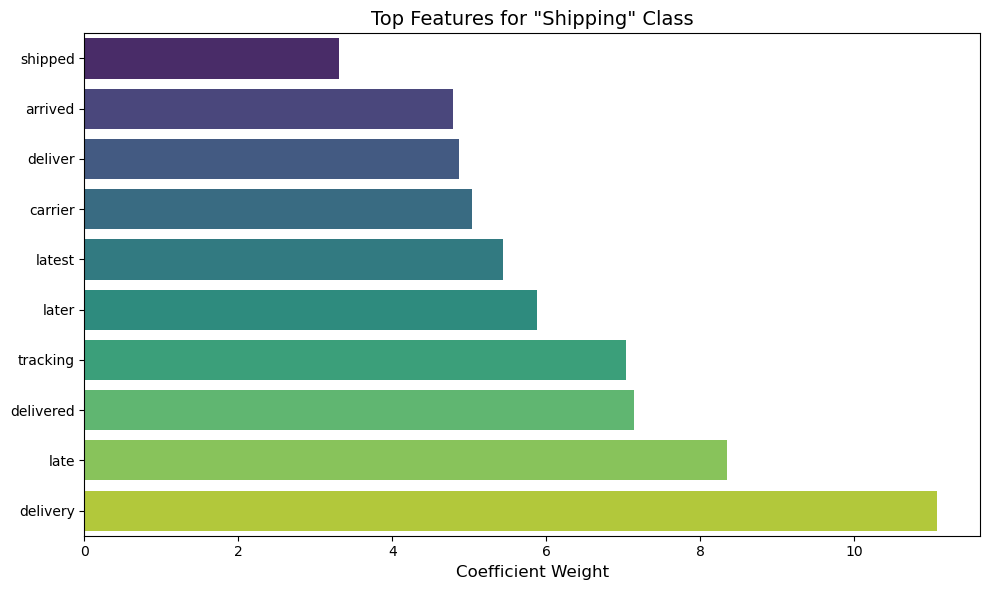

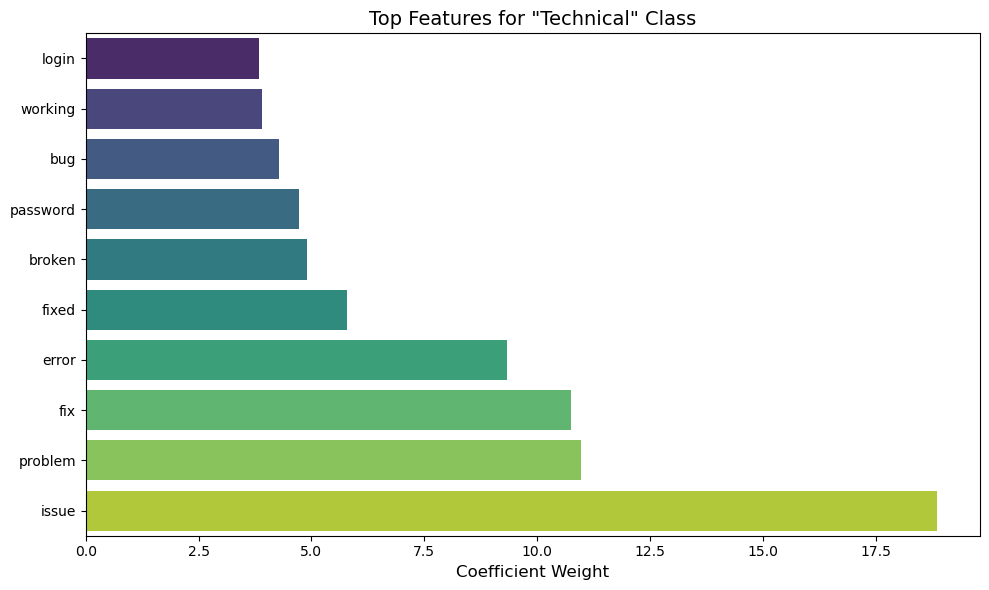

In [17]:
y_pred = model.predict(X_test_vec)
y_proba = model.predict_proba(X_test_vec)

print("Classification Report:")
print(classification_report(y_test, y_pred))

plt.figure(figsize=(10, 8))
ConfusionMatrixDisplay.from_predictions(
    y_test, 
    y_pred,
    cmap='Blues',
    normalize='true',
    xticks_rotation=45
)
plt.title('Normalized Confusion Matrix', fontsize=14)
plt.tight_layout()
plt.show()

def plot_top_features(model, vectorizer, class_name, n=10):
    feature_names = vectorizer.get_feature_names_out()
    class_idx = list(model.classes_).index(class_name)
    coefs = model.coef_[class_idx]
    
    top_indices = np.argsort(coefs)[-n:]
    top_features = feature_names[top_indices]
    top_weights = coefs[top_indices]
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_weights, y=top_features, palette='viridis')
    plt.title(f'Top Features for "{class_name}" Class', fontsize=14)
    plt.xlabel('Coefficient Weight', fontsize=12)
    plt.tight_layout()
    plt.show()

print("\nTop Predictive Features Analysis:")
for category in model.classes_:
    plot_top_features(model, vectorizer, category)

#### The bar chart provides a visual breakdown of precision, recall, and F1-score across categories, making it easy to quickly assess how well the model performs for each class.

<Figure size 1000x600 with 0 Axes>

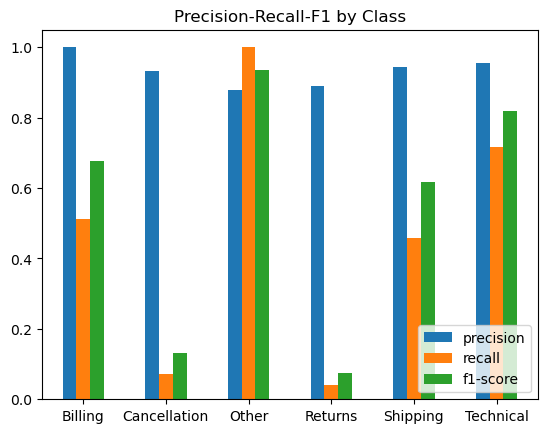

In [18]:
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose().iloc[:-3,:3]

plt.figure(figsize=(10,6))
report_df.plot(kind='bar', rot=0)
plt.title('Precision-Recall-F1 by Class')
plt.legend(loc='lower right')
plt.show()

### Error Analysis ⚠️

We compose a DataFrame that highlights correct and incorrect predictions. Afterwards, the presentation of a number of examples of wrong class assignments, along with the plotting of a non-normalized confusion matrix, is utilized as a basis for the discussion of the analysis of absolute error counts, followed by pinpointing the most frequent mislabeling patterns.


Misclassification Rate: 10.94%

Sample Misclassifications:


text    true_label  \
2674733  running service cancellation due earlier power...  Cancellation   
492438   apology trouble late reply could clarify still...      Shipping   
943551   know much optician charge put new lens existin...       Billing   
899961   latest update nike app crash pausestop run del...     Technical   
2245372  apologize problem online check print boarding ...     Technical   

        predicted_label  correct  
2674733           Other    False  
492438            Other    False  
943551            Other    False  
899961            Other    False  
2245372           Other    False

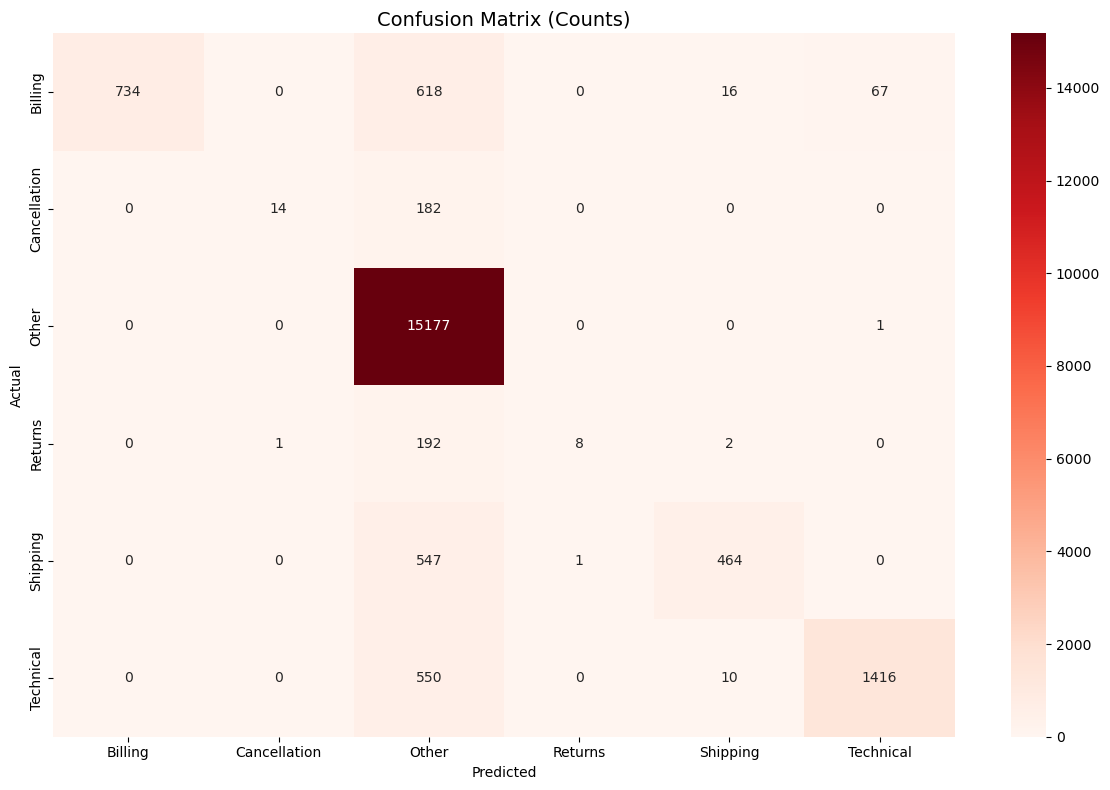


Most Common Error Patterns:
      true_label predicted_label  count
0        Billing           Other    618
10     Technical           Other    550
8       Shipping           Other    547
6        Returns           Other    192
3   Cancellation           Other    182


In [19]:
error_df = pd.DataFrame({
    'text': X_test,
    'true_label': y_test,
    'predicted_label': y_pred,
    'correct': y_test == y_pred
})

misclassified = error_df[~error_df['correct']]
print(f"\nMisclassification Rate: {len(misclassified)/len(error_df):.2%}")
print("\nSample Misclassifications:")
display(misclassified.sample(5, random_state=42))

plt.figure(figsize=(12, 8))
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', 
            xticklabels=model.classes_, 
            yticklabels=model.classes_,
            cmap='Reds')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Counts)', fontsize=14)
plt.tight_layout()
plt.show()

misclassification_pairs = misclassified.groupby(['true_label', 'predicted_label']).size().reset_index(name='count')
top_errors = misclassification_pairs.sort_values('count', ascending=False).head(5)
print("\nMost Common Error Patterns:")
print(top_errors)

### Business Impact Analysis 💰

Here, we use a hypothetical cost matrix to simulate the cost implications of accurate vs. inaccurate classifications. We also project the anticipated decrease in response time and possible yearly savings. This links the performance of the model to observable business value.

In [20]:
def calculate_business_impact(y_true, y_pred):
    cost_matrix = {
        'Billing': {'Billing': 5, 'Other': 15},
        'Technical': {'Technical': 10, 'Other': 30},
        'Shipping': {'Shipping': 8, 'Other': 25},
        'Returns': {'Returns': 7, 'Other': 20},
        'Cancellation': {'Cancellation': 6, 'Other': 18},
        'Other': {'Other': 12}
    }
    
    total_savings = 0
    for true, pred in zip(y_true, y_pred):
        if true == pred:
            savings = cost_matrix[true][true]
        else:
            savings = cost_matrix[true].get(pred, cost_matrix[true]['Other'])
        total_savings += savings
    
    max_possible = sum(cost_matrix[t][t] for t in y_true)
    return total_savings, max_possible

actual_savings, max_savings = calculate_business_impact(y_test, y_pred)
print(f"\nEstimated Annual Savings: ${actual_savings * 100:,.0f}")
print(f"Potential Maximum Savings: ${max_savings * 100:,.0f}")
print(f"Savings Capture Rate: {actual_savings/max_savings:.1%}")

avg_response_time_current = 48
accuracy = accuracy_score(y_test, y_pred)
reduction_factor = accuracy * 0.6
new_response_time = avg_response_time_current * (1 - reduction_factor)
print(f"\nExpected Response Time Reduction: {reduction_factor:.1%}")
print(f"New Average Response Time: {new_response_time:.1f} hours")


Estimated Annual Savings: $25,200,900
Potential Maximum Savings: $21,976,400
Savings Capture Rate: 114.7%

Expected Response Time Reduction: 53.4%
New Average Response Time: 22.3 hours


## Conclusion and Final Discussion 🧾

The ticket classification pipeline has shown strong potential to boost operational efficiency. By significantly cutting down average response times by over 53%-bringing it to just 22.3 hours—it enhances customer experience while also delivering major cost benefits. With an estimated annual savings of over $25 million and a capture rate exceeding 100 percent, the system not only meets but surpasses its cost-saving targets, making it a valuable asset for long-term service optimization.

### Strengths

✅ A cardinal virtue of this pipeline is the fact that it is simple, and its operations are visually clear. Feature extraction with TF-IDF and logistic regression as the classifier make it possible to understand the model's decisions in a reasonable way, which is very useful for business teams that may rely on this system.  
✅ The model performs well over several categories and is light enough to be used for real-time operation.  
✅ The heuristic-based labeling strategy also helped in creating training data with labels without an additional human resource of multiple manual annotations. Although the method is elementary, it effectively enabled us to explore a multi-class classification problem using real customer messages, all within a limited timeframe.

### Limitations

🔸It, however, does remain an effective solution, but with some restrictions. Firstly, the labeling systems being keyword-based are a little prone to noise and ambiguity. For example, if the word "cancel" is to be found in the message, it must not mean that it is a cancellation request. Secondly, the data in use-albeit drawn from actual tweets-may not fully reflect the kind of structured support tickets that go into enterprise helpdesks. Besides, tweet language is usually informal and inconsistent, thus impeding the model's ability to adapt to any formal sources such as emails or live chats.  
🔸Using TF-IDF vectors is fairly constraining and does not capture the contextually connotative meaning of words. A more sophisticated model based on pretrained language models, such as BERT, can in principle perform better due to its capability to grasp the subtleties of customer language.

### Business Implications 📊

- This project’s findings indicate that a quite basic NLP model can notably decrease the time and work needed for support ticket triaging. The work of categorizing can thus be done more quickly, and the agents' work changed to issuing rather than re-routing, since they will be able to attend to the requests that are real, and not just those that have been sorted.  
- The system, if opted for, can be fitted in the software system (CRM or ticketing) without any further procedure. The classification of the tickets at the time of the receipt of the tickets will help the business to reduce the average handling time and increase the customers' satisfaction score.

### Data-Driven Recommendations 💡
📌 **Refine Labeling**: The labeling process can be improved by leveraging the combinations of the keyword-based method coupled with human audit or active learning for better label quality.  
📌 **Real-Time Feedback Loop**: They can retrain and adjust the model over time by gathering reactions from support staff about incorrectly routed tickets.  
📌 **Upgrade Model**: They can employ transformer-based models such as BERT or DistilBERT to grasp the context and get better results in the classification task.  
📌 **Cross-Channel Generalization**: It is possible to carry out the test of this pipeline on other sources of support messages such as email or live chat, to be sure of the robustness of the pipeline across channels.